# **Шаг 1**: Разведочный анализ метаданных

Загрузим стандартные библиотеки для работы с данными и визуализации:

In [1]:
import numpy as np                  
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os

В тренировочном и тестовом наборе присутствуют таблицы с данными пациенток, у которых была проведена маммография.

**Содержание колонок:**
- image_id, site_id, patient_id, machine_id - идентификаторы снимков, пациентов, госпиталей и аппарата.
- laterality - маркер снимка левой и правой груди
- view - ориентация снимка
- age - возраст пациентки
- implant - наличие грудных имплантов
- density - плотность ткани
- biopsy - флаг проведения последующей биопсии
- invasive - для положительных случаев - инвазивный ли рак?
- BIRADS - флаг необходимости последующего наблюдения
- difficult_negative_case - для отрицательных случаев - сложный ли случай?
- cancer - флаг наличия заболевания
- prediction_id - The ID for the matching submission row (?)

Колонки biopsy, invasive, BIRADS, difficult_negative_case, cancer, rediction_id присутствуют только в тренировочном датасете.

Посмотрим на тренировочный датасет:

In [2]:
df_train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
df_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


Похоже на правду. Есть пропуски, посмотрим, насколько их много.

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
dtypes: bool(1), float64(2)

В 1% наблюдений неизвестен возраст, значительная доля пропусков в колонках BIRADS и density.

Далее изучим внимательно содержание различных колонок.

Посмотрим, (1) сколько госпиталей и (2) пациенток приняло участие в исследовании:

In [4]:
print(f'Данные собраны в {df_train.site_id.nunique()} госпиталях у {df_train.patient_id.nunique()} пациенток.')

Данные собраны в 2 госпиталях у 11913 пациенток.


Оценим сбалансированность датасета по ключевой переменной.

In [5]:
print(f'Процент снимков с онкологией: {round(sum(df_train["cancer"])/len(df_train)*100)}\n\
Процент пациенток с онкологией: {round((df_train[df_train["cancer"] == 1]["patient_id"].nunique()/(df_train["patient_id"].nunique())*100),2)}')

Процент снимков с онкологией: 2
Процент пациенток с онкологией: 4.08


Посмотрим процент инвазивного рака у пациенток с онкологией. У пациенток с отсутствием онкологии оценим процент сложных случаев


In [6]:
df_train_canc = df_train[df_train.cancer == 1]
df_train_noncanc = df_train[df_train.cancer == 0]
df_train_canc_inv = round(len(df_train_canc[df_train_canc.invasive == 1])/len(df_train_canc)*100,2)
df_train_noncanc_difc = round(len(df_train_noncanc[df_train_noncanc.difficult_negative_case == 1])/len(df_train_noncanc)*100,2)
print(f'Процент случаев инвазивного рака груди: {df_train_canc_inv}\n\
Процент сложных негативных случаев: {df_train_noncanc_difc}')

Процент случаев инвазивного рака груди: 70.64
Процент сложных негативных случаев: 14.39


Оценим количество снимков у пациенток с онкологией и без:

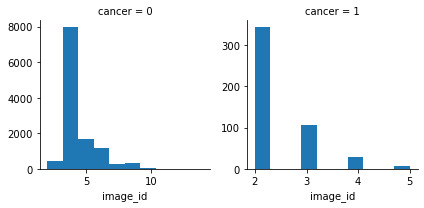

In [7]:
df_stat_img = df_train[['patient_id','cancer','image_id']].\
groupby(['patient_id','cancer']).count().reset_index()

g=sns.FacetGrid(df_stat_img, col="cancer", sharey=False, sharex=False)
g=g.map(plt.hist,'image_id')

В датасете есть снимки как левой так и правой груди, за которые отвечает колонка laterality, проверим эту колонку и посмотрим, какая доля наблюдений приходися на каждую грудь.

In [8]:
R_perc = round(len(df_train[df_train.laterality == "R"])/(len(df_train)),2)
print(f'Доля наблюдений для правой груди: {R_perc}, левой груди:{1 - R_perc}')

Доля наблюдений для правой груди: 0.5, левой груди:0.5


В датасете равное количество снимок для двух грудей.

Снимки сделаны с разных позиций, что отражено в колонке view. Посмотрим, какие позиции у нас есть в датасете и проверим их долю в датасете: 

In [9]:
df_train.groupby('view')['image_id'].count()/len(df_train)*100

view
AT      0.034731
CC     48.925164
LM      0.018280
LMO     0.001828
ML      0.014624
MLO    51.005374
Name: image_id, dtype: float64

Видим, что большинство снимков сделаны в проекциях CC и MLO.

Возраст является важным фактором при диагностике злокачественных новообразований. Посмотрим насколько отличается возраст пациенток в зависимости от диагноза.

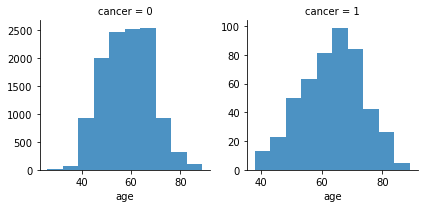

In [10]:
df_age = df_train[['patient_id','age','cancer']].drop_duplicates()
df_age['count_by_diagnosis'] = df_age.\
groupby('cancer')['patient_id'].\
transform('count')

#sns.histplot(df_age, x='age', hue='cancer', stat='percent')

g=sns.FacetGrid(df_age, col="cancer", sharey=False, sharex=False)
g=g.map(plt.hist,'age',alpha = 0.8)

In [11]:
## Mann Whitney U test.
from scipy.stats import mannwhitneyu
mannwhitneyu(df_train[df_train['cancer']==0]['age'].dropna(),
            df_train[df_train['cancer']==1]['age'].dropna())

MannwhitneyuResult(statistic=21818813.0, pvalue=1.0248918387012223e-66)

Отмечаются статистически значимые различия в возрасте пациенток с онкологией и без.

Часть значений возраста отсутствует, заполним их медианой по группе:

In [12]:
df_train['age']= df_train['age'].\
fillna(df_train.groupby('cancer')['age'].transform('mean'))
df_train['age'].isna().sum()

0



Теперь изучим показатели density и BIRADS:



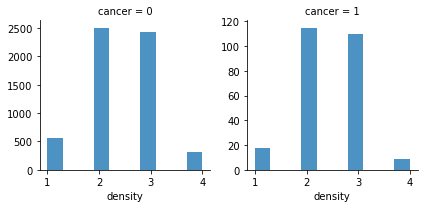

In [13]:
## есть ли различия в плотности между отрицательными и положительными случаями?
df_dense = df_train[['patient_id','density','cancer']].drop_duplicates().dropna()
df_dense['density'] = df_dense['density'].replace({'A': 1,'B': 2,'C' : 3, 'D' : 4})

df_dense.head()
g=sns.FacetGrid(df_dense, col="cancer", sharey=False)
g=g.map(plt.hist,'density',alpha = 0.8)

Нет отличий в показателе Density между группами пациенток. Информация по параметру отсутствует для значительной доли наблюдений, поэтому мы не будем включать его в рассмотрение.

Посмотрим на процент пациенток с имплантами, как с онкологией так и без.

In [14]:
df_train[['patient_id','implant','cancer']].\
drop_duplicates().\
groupby(['implant','cancer']).count()

patient_id
implant cancer            
0       0            11736
        1              483
1       0              171
        1                3

**Основные выводы:**
1. Датасет несбалансирован по группам с онкологией и без. Для тренировки модели имеет смысл исключить значительную часть наблюдений без онкологии
2. Включение возраста пациенток в модель может улучшить метрики качества
3. Значительная доля пропусков в колонке BIRADS. Колонки BIRADS и difficult_negative_case представлены только в тренировочном наборе. Не имеет смысла использовать их в качестве признаков.
4. В тренировочном наборе есть небольшая часть снимков пациенток с имплантами

# **Шаг 2**: Анализ DICOM файлов

Импортируем библиотеки для работы с папками и dicom файлами:

In [15]:
import os
import glob

import pydicom
!pip uninstall pylibjpeg -y
!pip uninstall python_gdcm -y
#try:
#    import pylibjpeg
    
#except:
!pip install /kaggle/input/rsna-packages/{pydicom-2.3.0-py3-none-any.whl,pylibjpeg-1.4.0-py3-none-any.whl,python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl}
   # !pip download pylibjpeg==1.4.0
   # !pip download pydicom==2.3.0
   # !pip download python_gdcm==3.0.15
   # !pip install /kaggle/working/{pydicom-2.3.0-py3-none-any.whl,pylibjpeg-1.4.0-py3-none-any.whl,python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl}

Found existing installation: pylibjpeg 1.4.0
Uninstalling pylibjpeg-1.4.0:
  Successfully uninstalled pylibjpeg-1.4.0
Found existing installation: python-gdcm 3.0.15
Uninstalling python-gdcm-3.0.15:
  Successfully uninstalled python-gdcm-3.0.15
Processing /kaggle/input/rsna-packages/pydicom-2.3.0-py3-none-any.whl
Processing /kaggle/input/rsna-packages/pylibjpeg-1.4.0-py3-none-any.whl
Processing /kaggle/input/rsna-packages/python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
pydicom is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [16]:
!pip install /kaggle/input/rsna-packages/{pydicom-2.3.0-py3-none-any.whl,pylibjpeg-1.4.0-py3-none-any.whl,python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl}


Processing /kaggle/input/rsna-packages/pydicom-2.3.0-py3-none-any.whl
Processing /kaggle/input/rsna-packages/pylibjpeg-1.4.0-py3-none-any.whl
Processing /kaggle/input/rsna-packages/python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
pydicom is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
pylibjpeg is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
python-gdcm is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


В этой части мы будем случайным образом выбирать изображения, поэтому зафиксируем генератор случайных чисел для воспроизводимости

Посмотрим струкутру папок:

In [17]:
train_path = '/kaggle/input/rsna-breast-cancer-detection/train_images'
train_data_list = glob.glob(train_path + '/*/*.dcm')
train_data_list[:5]

['/kaggle/input/rsna-breast-cancer-detection/train_images/10706/763186195.dcm',
 '/kaggle/input/rsna-breast-cancer-detection/train_images/10706/937109986.dcm',
 '/kaggle/input/rsna-breast-cancer-detection/train_images/10706/34700621.dcm',
 '/kaggle/input/rsna-breast-cancer-detection/train_images/10706/1167990339.dcm',
 '/kaggle/input/rsna-breast-cancer-detection/train_images/21867/1291014447.dcm']

Пропишем в датасет пути к файлам

In [18]:
df_train['image_path'] =  '/kaggle/input/rsna-breast-cancer-detection/train_images/' + df_train.patient_id.map(str) + \
'/' + df_train.image_id.map(str) + '.dcm'

df_train.iloc[0]['image_path']

'/kaggle/input/rsna-breast-cancer-detection/train_images/10006/462822612.dcm'

Теперь возьмем любой из файлов и посмотрим, что из себя представляет DICOM:

In [19]:
ds = pydicom.dcmread(train_data_list[1], force = True)
ds

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.10706.1.937109986
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.10706.1.937109986
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '184027.212260'
(0010, 0020) Patient ID                          LO: '10706'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.10706
(0020, 000e) Series Instance U

Часть колонок содержит информацию, которая есть в csv(id_patient, id_site, laterality,view).
Теперь посмотрим на пример изображения.

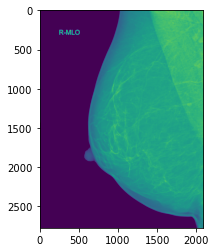

In [20]:
plt.imshow(ds.pixel_array)

Видим, что на картинке есть артефакты (буквы), которые нужно будет убрать.

**Теперь визуализируем разные изображения:**

- разные проекции
- онко vs норма
- импланты
- сложные негативные случаи
- photometric interpretation

Напишем функцию для визуализации:

In [21]:
import random
random.seed(0)  ## зафиксируем seed для воспроизводимости

def plot_img(img_ds):
    img_ds['cancer_str'] = img_ds['cancer'].replace({0:'healthy', 1:'cancer'})

    plt.figure(figsize=(12,10))
    for n in range(len(img_ds)):
        id_ds = pydicom.dcmread(img_ds.iloc[n]['image_path'], force = True)
        ax = plt.subplot(3,len(img_ds)//3 + 1, n + 1)
        ax.set_title(img_ds.iloc[n]['view'] + ' | ' + \
                 img_ds.iloc[n]['cancer_str'])
        plt.imshow(id_ds.pixel_array, cmap="turbo")

**Визуализируем разные проекции:**

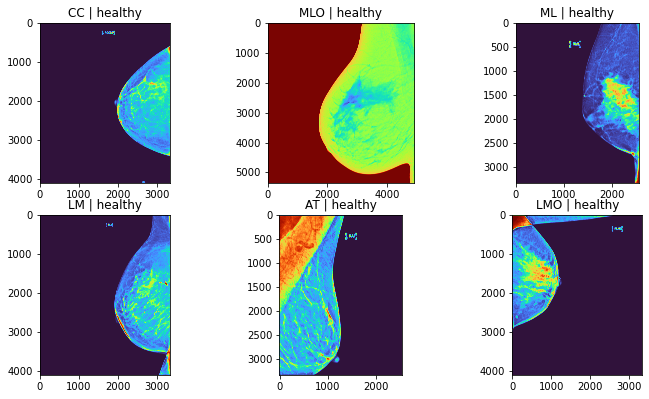

In [22]:

## про разные проекции https://radiopaedia.org/articles/mammography-views
id_paths = df_train[(df_train.cancer == 1) & (df_train.cancer == 0)]
for im_view in df_train['view'].unique():
    df_view = df_train[(df_train['view'] == im_view) & 
                       (df_train['laterality'] == 'R')]
    id_view = df_view.iloc[[random.randrange(len(df_view))]]
    id_paths = pd.concat([id_paths, id_view], ignore_index = True) #.append(id_path)

plot_img(id_paths)

In [23]:
for i in id_paths.image_path:
    ds_i = pydicom.dcmread(i)
    print(ds_i.PhotometricInterpretation)

MONOCHROME2
MONOCHROME1
MONOCHROME2
MONOCHROME2
MONOCHROME2
MONOCHROME2


В датасете присутствуют данные, полученные при помощи различных фотометрических интерпретаций Monochrome1 и Monochrome2. При препроцессинге необходимо будет привести все к одной интерпретации.

Также видно, что размеры изображений отличаются, при препроцессинге необходимо будет свести все к одному размеру.

Далее сравним изображения с онкологией и без. Для начала выберем пациентку с онкологией и сравним здоровую и пораженную грудь.

In [24]:
id_onco = df_train[df_train.cancer == 1]['patient_id']
onco_example = df_train[df_train.patient_id == id_onco.iloc[2]]
onco_example

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,image_path
87,1,10130,388811999,L,MLO,71.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
88,1,10130,613462606,L,CC,71.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
89,1,10130,1360338805,L,CC,71.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
90,1,10130,1672636630,L,MLO,71.0,1,1,1,0.0,0,B,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
91,1,10130,1013166704,R,CC,71.0,0,0,0,NaN,0,B,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
92,1,10130,1165309236,R,CC,71.0,0,0,0,NaN,0,B,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...
93,1,10130,2110820077,R,MLO,71.0,0,0,0,NaN,0,B,49,False,/kaggle/input/rsna-breast-cancer-detection/tra...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


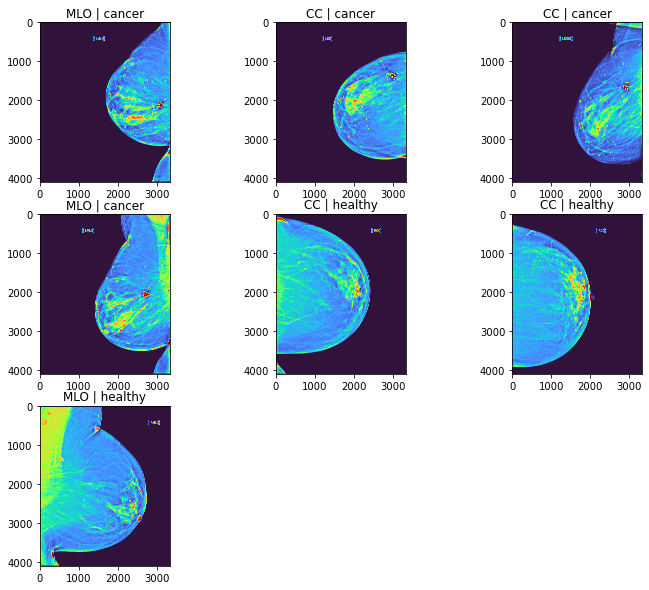

In [25]:
plot_img(onco_example)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


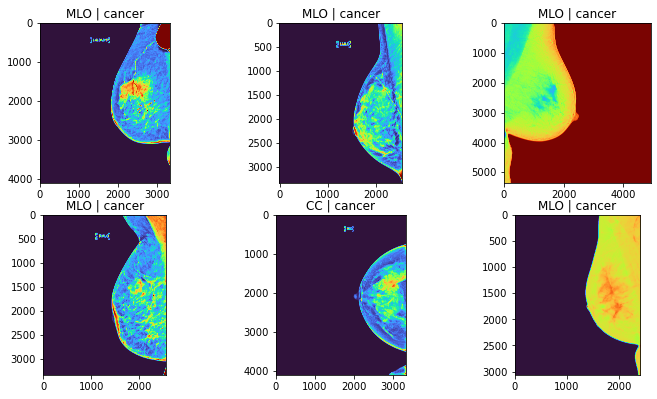

In [26]:
id_onco = df_train[df_train.cancer == 1]
id_onco_sample = id_onco.iloc[random.sample(range(0, len(id_onco)-1), 6)]
plot_img(id_onco_sample)

Теперь посмотрим, как на снимках выглядят импланты.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


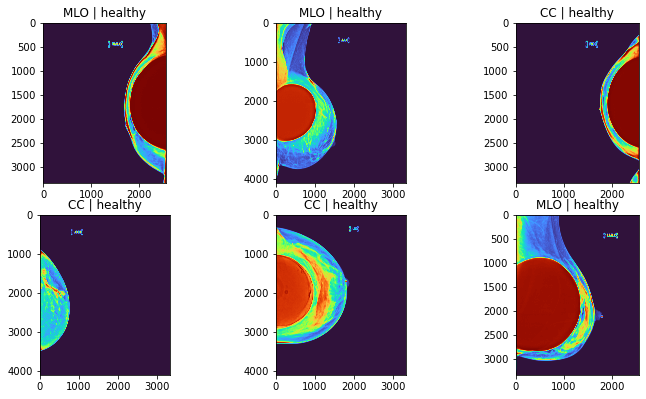

In [27]:
id_implant = df_train[df_train.implant == 1]
id_implant_sample = id_implant.iloc[random.sample(range(0, len(id_implant)-1), 6)]
plot_img(id_implant_sample)

Теперь посмотрим, как выглядит сложный негативный случай:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


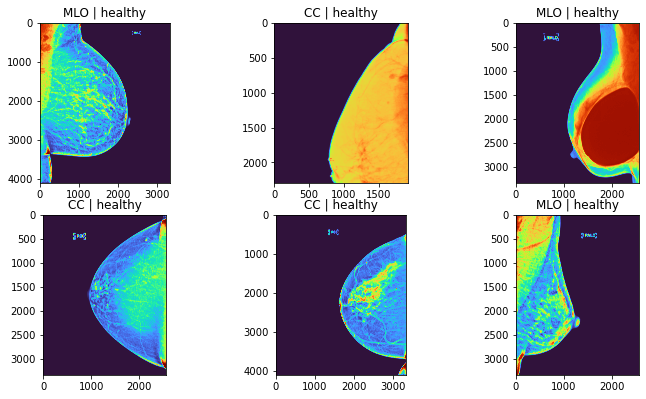

In [28]:
id_neg = df_train[df_train.difficult_negative_case == 1]
id_neg_sample = id_neg.iloc[random.sample(range(0, len(id_implant)-1), 6)]
plot_img(id_neg_sample)

Посмотрим, как выглядят случаи инвазивного рака:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


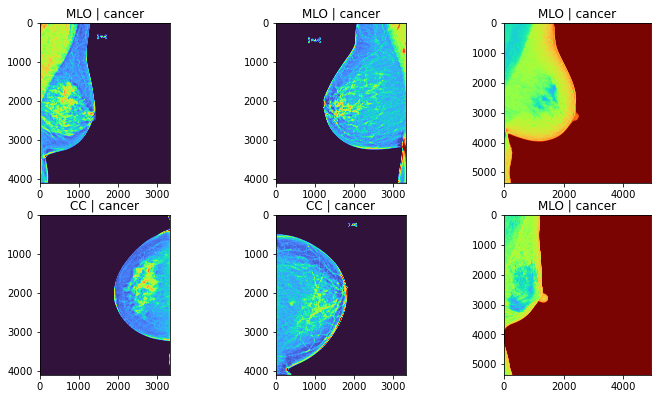

In [29]:
id_inv = df_train[df_train.invasive == 1]
id_inv_sample = id_inv.iloc[random.sample(range(0, len(id_inv)-1), 6)]
plot_img(id_inv_sample)

**Основные выводы по визуализации:**
- наличие артефактов на снимках -> требуется удаление
- неинформативные регионы -> требуется обрезка 
- разный размер изображений -> требуется обрезка
- два вида фотометрической интерпретации изображений -> необходимо свести к единой 
- сложно отличить онкологию от нормы -> использование фильтров (?) более плотная ткань, узелки (?)
- случаи с имплантами отличаются от других изображений -> включить инфо об имплантах из csv  в обучение

# Шаг 3: Анализ применения популярных фильтров на датасете

...

In [30]:
import cv2

In [92]:
def filt_vis(img_list):
    # img_list - list of images, tupple, [0]- image, [1] - filter used
    fig = plt.figure(figsize=(12,12))
    for n in range(len(img_list)):
        ax = plt.subplot(2,len(img_list)//2 + 1, n + 1)
        ax.set_title(img_list[n][1]) 
        plt.imshow(img_list[n][0], cmap="turbo")
        fig.tight_layout()

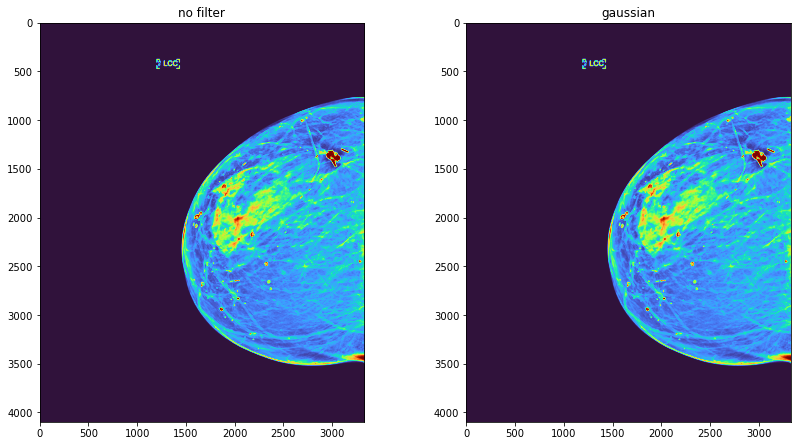

In [93]:
fig = df_train[df_train.cancer == 1]['image_path'].iloc[1] 
ds = pydicom.dcmread(fig, force = True)
img_nof = ds.pixel_array
kernel = np.ones((5,5),np.float32)/25
img_gaus = cv2.filter2D(img_nof,-1,kernel)
im_list = [(img_nof, 'no filter'), (img_gaus,'gaussian')]
filt_vis(im_list)

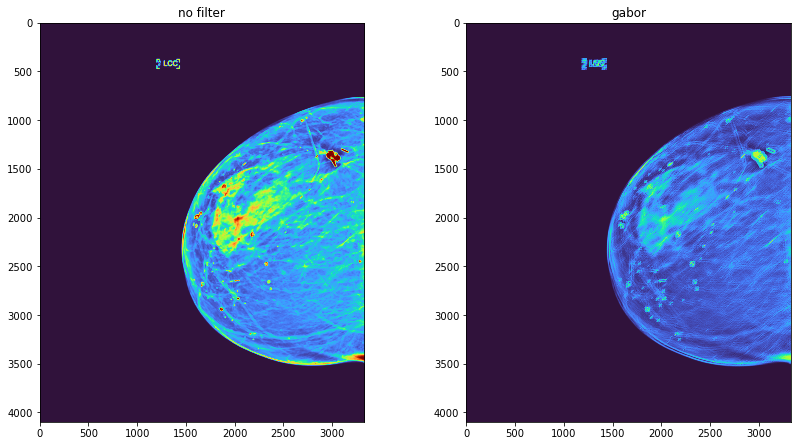

In [94]:
#https://gist.github.com/kendricktan/93f0da88d0b25087d751ed2244cf770c
gab_kernel = cv2.getGaborKernel((21, 21), 8.0, np.pi/4, 10.0, 0.5, 0, ktype=cv2.CV_32F)
img_gabor = cv2.filter2D(img_nof,-1,gab_kernel)
im_list = [(img_nof, 'no filter'), (img_gabor,'gabor')]
filt_vis(im_list)

In [90]:
#Experimenting with Gabor def create_gaborfilter() is taken - https://www.freedomvc.com/index.php/2021/10/16/gabor-filter-in-edge-detection/
def create_gaborfilter():
    # This function is designed to produce a set of GaborFilters 
    # an even distribution of theta values equally distributed amongst pi rad / 180 degree
     
    filters = []
    num_filters = 11
    ksize = 35  # The local area to evaluate
    sigma = 3.0  # Larger Values produce more edges
    lambd = 10.0
    gamma = 0.5
    psi = 0  # Offset value - lower generates cleaner results
    for theta in np.arange(0, np.pi, np.pi / num_filters):  # Theta is the orientation for edge detection
        kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
        kern /= 1.0 * kern.sum()  # Brightness normalization
        filters.append(kern)
    return filters, np.arange(0, np.pi, np.pi / num_filters)

gfilters = create_gaborfilter()
g_filt = [(img_nof, 'no filter')]

for i,k in zip(gfilters[0],gfilters[1]):
    img_i = cv2.filter2D(img_nof,-1,i)
    g_filt.append((img_i,str(round(k,2))))

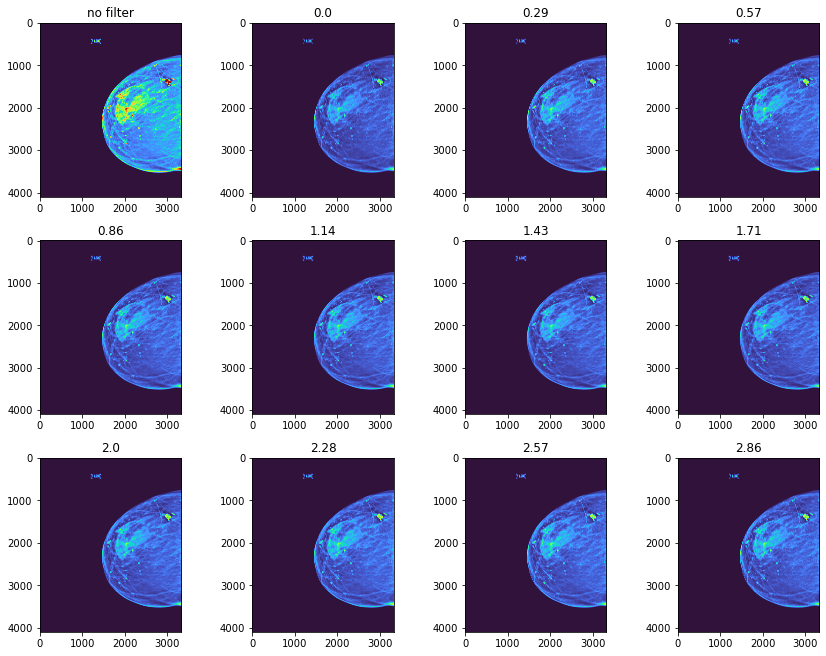

In [91]:
def filt_vis(img_list):
    # img_list - list of images, tupple, [0]- image, [1] - filter used
    fig = plt.figure(figsize=(12,12))
    for n in range(len(img_list)):
        ax = plt.subplot(4,len(img_list)//4 + 1, n + 1)
        ax.set_title(img_list[n][1]) 
        plt.imshow(img_list[n][0], cmap="turbo")
        fig.tight_layout()
filt_vis(g_filt)

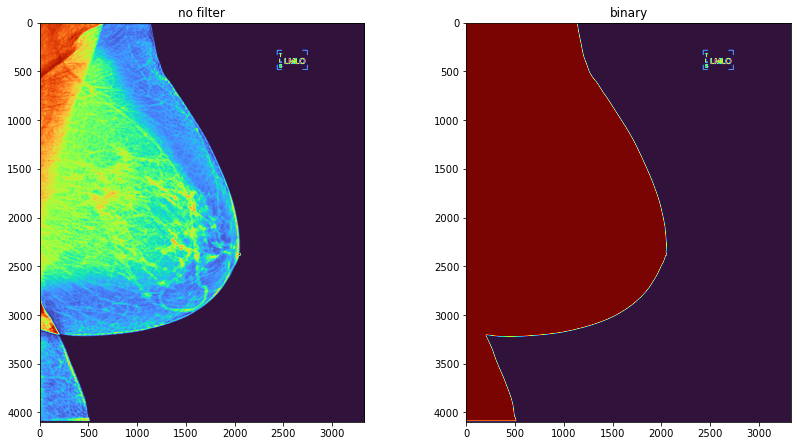

In [78]:
img_bin = cv2.threshold(img_nof, 20, 255, cv2.THRESH_BINARY)[1]
im_list = [(img_nof, 'no filter'), (img_bin,'binary')]
filt_vis(im_list)